

---


# Downloading Data And Preparing Folders


---



In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

 85% 84.0M/98.7M [00:01<00:00, 56.1MB/s]
100% 98.7M/98.7M [00:01<00:00, 53.3MB/s]


In [ ]:
!unzip /content/melanoma-skin-cancer-dataset-of-10000-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: melanoma_cancer_dataset/train/benign/melanoma_643.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_644.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_645.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_646.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_647.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_648.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_649.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_65.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_650.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_651.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_652.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_653.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_654.jpg  
  inflating: melanoma_cancer_dataset/train/benign/mel



---


# Model Architecture And Training


---



In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.layers import  SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Conv2D, Flatten, Dropout, Dense , Input
from keras import layers,  Model
from keras.callbacks import EarlyStopping , ReduceLROnPlateau , LearningRateScheduler, ModelCheckpoint
from keras.optimizers import RMSprop, Adam
import random
import matplotlib.pyplot as plt
from PIL import Image
from skimage.util import random_noise
from skimage import exposure, color, transform
from scipy.ndimage import gaussian_filter
from keras.applications import ResNet50, VGG16
from  keras.applications.resnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np

# Directories
train_dir = '/content/melanoma_cancer_dataset/train'
val_dir = '/content/melanoma_cancer_dataset/test'

# MASK IMAGES AND ADD RANDOM BLURING TO SIMULATE IMAGES CAPTURES ON PHONE
def mask_image(image, blur_probability=0.5, blur_kernel_size=(3, 3)):
    add_blur = np.random.rand() < blur_probability

    if add_blur:
        blurred_image = cv2.GaussianBlur(image, blur_kernel_size, 0)
    else:
        blurred_image = image

    height, width = blurred_image.shape[:2]

    mask = np.zeros((height, width), dtype=np.uint8)

    center = (width // 2, height // 2)
    radius = min(width, height) // 2

    cv2.circle(mask, center, radius, (255, 255, 255), thickness=-1)

    masked_image = cv2.bitwise_and(blurred_image, blurred_image, mask=mask)

    return masked_image

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=mask_image
)

validation_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=mask_image)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300,300),
    batch_size=35,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(300,300),
    batch_size=35,
    class_mode='binary'

)

base_model = VGG16(include_top=False,
                      weights='imagenet',
                      input_shape=(300, 300, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the last few layers of the base VGG16 model
for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

model.summary()

def lr_scheduler(epoch):
    if epoch < 10:
        return 1e-5
    else:
        return 1e-6
lr_schedule = LearningRateScheduler(lr_scheduler)

early_stopping = EarlyStopping(monitor='accuracy', patience=15, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)


checkpoint_filepath = '/content/checkpoint_melnet_cnn_VGG16_finetuned_phone.h5'

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

callbacks = [early_stopping, lr_schedule, learning_rate_reduction, model_checkpoint]

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    epochs=25,
    validation_steps=28,
    callbacks=callbacks
)

model.save('/content/melnet_cnn_VGG16_finetuned_phone.h5')


Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 143s 1s/step - loss: 0.4342 - accuracy: 0.8009 - val_loss: 0.5262 - val_accuracy: 0.8673 - lr: 1.0000e-05
Epoch 2/25
100/100 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.8711
Epoch 2: val_accuracy did not improve from 0.86735
100/100 [==============================] - 109s 1s/step - loss: 0.3020 - accuracy: 0.8711 - val_loss: 0.5160 - val_accuracy: 0.6816 - lr: 1.0000e-05
Epoch 3/25
100/100 [==============================] - ETA: 0s - loss: 0.2862 - accuracy: 0.8799
Epoch 3: val_accuracy improved from 0.86735 to 0.88571, saving model to /content/checkpoint_melnet_cnn_VGG16_finetuned_phone.h5
100/100 [==============================] - 112s 1s/step - loss: 0.2862 - accuracy: 0.8799 - val_loss: 0.3106 - val_accuracy: 0.8857 - lr: 1.0000e-05
Epoch 4/25
100/100 [==============================] - ETA: 0s - loss: 0.2745 - accuracy: 0.8807
Epoch 4: val_accuracy did not improve from 0.88571
100/100 [==========================



---

Quickly Plotting Accuracey



---

It can be shown that the model hasen't been overfitted.

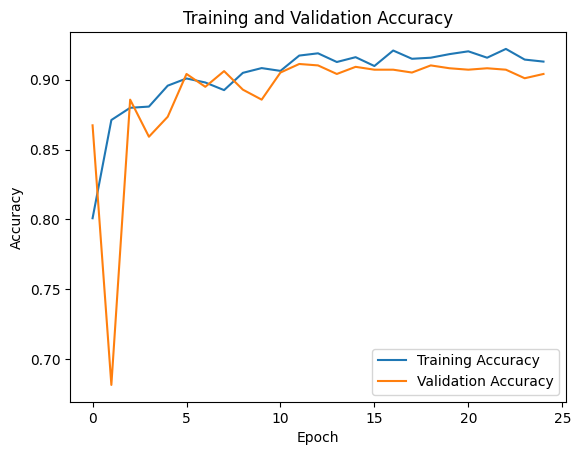

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()



---


# Test Heat Map Vizualization


---



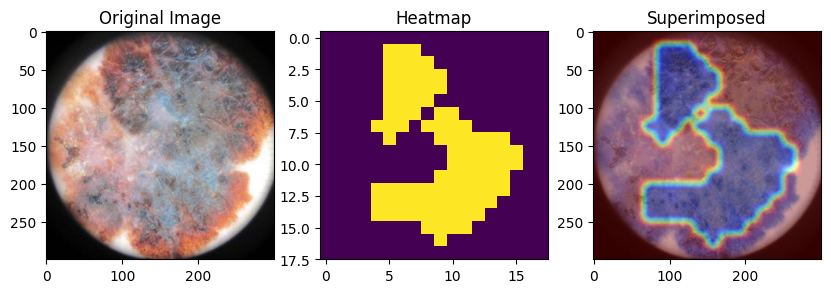

{'prediction': 'The model predicts melanoma (Cancerous) at 100.00%'}


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image
from keras import backend as K

tf.compat.v1.disable_eager_execution()

def load_and_preprocess_image(image_path, target_size=(300, 300)):
    img = Image.open(image_path).resize(target_size)
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img

def preprocess_image(image):
    image = image.resize((300, 300))
    image = np.array(image)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

model_path = '/content/checkpoint_melnet_cnn_VGG16_finetuned_phone.h5'

model = keras.models.load_model(model_path)


img_path = '/content/melanoma_cancer_dataset/test/malignant/melanoma_10502.jpg'
x = load_and_preprocess_image(img_path)

last_conv_layer = model.get_layer('block5_conv3')
model_output = model.output

grads = K.gradients(model_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(conv_layer_output_value.shape[-1]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Threshold the heatmap to get regions where melanoma is detected the most. Leads to smoother edges for heatmap and gets rid of mist.
threshold = 0.6
melanoma_heatmap = np.zeros_like(heatmap)
melanoma_heatmap[heatmap >= threshold] = 1



# Overlay heatmap on the original image only where melanoma is detected
img = cv2.imread(img_path)
heatmap_resized = cv2.resize(melanoma_heatmap, (img.shape[1], img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap_resized, 0.4, 0)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(Image.open(img_path))
axs[0].set_title('Original Image')
axs[1].imshow(melanoma_heatmap, cmap='viridis')
axs[1].set_title('Heatmap')
axs[2].imshow(superimposed_img, cmap='summer')
axs[2].set_title('Superimposed')
plt.show()

image = Image.open(img_path)
image = preprocess_image(image)
prediction = model.predict(image)
prediction_percentage = prediction[0][0] * 100
result = {
    "prediction": f"The model predicts melanoma (Cancerous) at {prediction_percentage:.2f}%" if prediction_percentage > 50 else f"The model predicts no melanoma (Non - Cancerous) at {prediction_percentage:.2f}%",
}
print(result)

Note the mask surrounding the orignal image. The model ignores it during classification as a result of the use of the masking function as a part of the data preprocessing step.

# Test on image of a suspicous legion taken with an iphone camera

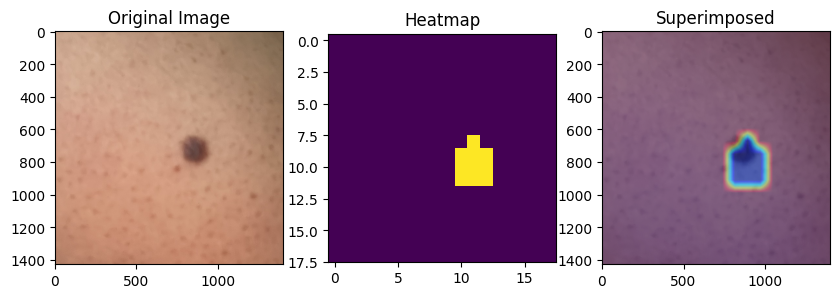

{'prediction': 'The model predicts melanoma (Cancerous) at 99.45%'}


In [ ]:
tf.compat.v1.disable_eager_execution()

img_path = '/content/IMG_4141.jpg'
x = load_and_preprocess_image(img_path)

last_conv_layer = model.get_layer('block5_conv3')
model_output = model.output

grads = K.gradients(model_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(conv_layer_output_value.shape[-1]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

threshold = 0.6
melanoma_heatmap = np.zeros_like(heatmap)
melanoma_heatmap[heatmap >= threshold] = 1

img = cv2.imread(img_path)
heatmap_resized = cv2.resize(melanoma_heatmap, (img.shape[1], img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap_resized, 0.4, 0)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(Image.open(img_path))
axs[0].set_title('Original Image')
axs[1].imshow(melanoma_heatmap, cmap='viridis')
axs[1].set_title('Heatmap')
axs[2].imshow(superimposed_img, cmap='summer')
axs[2].set_title('Superimposed')
plt.show()

image = Image.open(img_path)
image = preprocess_image(image)
prediction = model.predict(image)
prediction_percentage = prediction[0][0] * 100
result = {
    "prediction": f"The model predicts melanoma (Cancerous) at {prediction_percentage:.2f}%" if prediction_percentage > 50 else f"The model predicts no melanoma (Non - Cancerous) at {prediction_percentage:.2f}%",
}
print(result)



---


# API


---



In [ ]:
from flask import Flask, request, jsonify
from PIL import Image
import numpy as np
import io
import base64
import cv2
from keras import backend as K
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

app = Flask(__name__)

def load_model():
    model = tf.keras.models.load_model('/content/checkpoint_melnet_cnn_VGG16_finetuned_phone.h5')
    return model

def preprocess_image(image):
    image = image.resize((300, 300))
    image = np.array(image)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

def load_cam_heatmap(mdl, image, last_conv_layer_name, threshold=0.5):
    model = mdl
    x = image
    last_conv_layer = model.get_layer(last_conv_layer_name)
    model_output = model.output

    grads = K.gradients(model_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])

    for i in range(conv_layer_output_value.shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    heatmap_masked = np.zeros_like(heatmap)
    heatmap_masked[heatmap >= threshold] = heatmap[heatmap >= threshold]

    img = (image[0] * 255).astype(np.uint8)
    heatmap_resized = cv2.resize(heatmap_masked, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_resized, 0.4, 0)

    return superimposed_img


@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Check if the POST request has a file part
        if 'file' not in request.files:
            return jsonify({"error": "No file part"})

        file = request.files['file']

        # Check if the file is empty
        if file.filename == '':
            return jsonify({"error": "No selected file"})

        # Read the image file
        image = Image.open(io.BytesIO(file.read()))
        model = load_model()

        # Preprocess the image
        image = preprocess_image(image)

        last_convolution_layer = 'block5_conv3'
        superimposed_img = load_cam_heatmap(model, image, last_convolution_layer)

        # Prepare response data
        prediction = model.predict(image)
        prediction_percentage = prediction[0][0] * 100
        prediction_result = ("melanoma (Cancerous)" if prediction_percentage > 50 else "benign (Non - Cancerous)")
        confidence_val = prediction_percentage if prediction_percentage > 50 else 100 - prediction_percentage

        # Convert the superimposed image to base64
        _, buffer = cv2.imencode('.jpg', superimposed_img)
        superimposed_img_base64 = base64.b64encode(buffer).decode('utf-8')

        response_data = {
            "prediction": {
                "result": prediction_result,
                "confidence": f"{confidence_val:.2f}%"
            },
            "superimposed_image": superimposed_img_base64
        }

        return jsonify(response_data)

    except Exception as e:
        print(e)
        return jsonify({"error": str(e)})

if __name__ == '__main__':
    app.run(host='0.0.0.0', debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
